In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
from keras_vggface.vggface import VGGFace
from keras.layers import Input

In [4]:
batch_size = 256
target_size = (224, 224)
input_shape=(224, 224, 3)
num_classes = 9
epochs=50

seed=1337
adam_lr = 0.001
FC = 2048
patience = 3
dense_dropout = 0.15
cnn_dropout = 0
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model_name = 'vggface_age_focal_combined.h5'

In [9]:
train_data = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_data = ImageDataGenerator( rescale = 1.0/255)

test_data = ImageDataGenerator( rescale = 1.0/255)

In [10]:
print("Training Data:")
# There are 7 different classes
train_generator = train_data.flow_from_directory('./ages_combined/Training',
                                                    batch_size =batch_size ,
                                                    class_mode = 'categorical',
                                                    seed=seed,
                                                    target_size = target_size )     

print("Validation Data:")
validation_generator =  validation_data.flow_from_directory( './ages_combined/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size)

print("Test Data:")
test_generator = test_data.flow_from_directory('./ages_combined/Test',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size)

Training Data:
Found 93547 images belonging to 9 classes.
Validation Data:
Found 9284 images belonging to 9 classes.
Test Data:
Found 4643 images belonging to 9 classes.


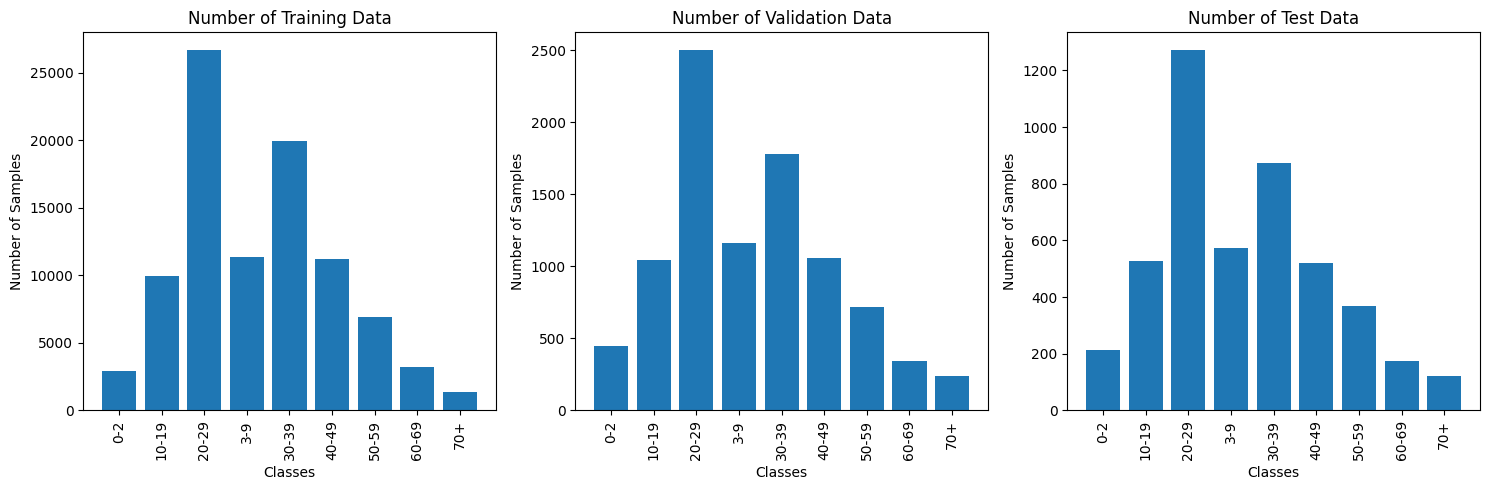

In [11]:
import os
import matplotlib.pyplot as plt

def count_files(directory):
    """
    Counts the number of files in each subdirectory of a given directory.
    Assumes that each subdirectory represents a class.
    """
    counts = []
    class_names = []
    # Walk through each subdirectory in the directory
    for subdir in sorted(os.listdir(directory)):
        path = os.path.join(directory, subdir)
        if os.path.isdir(path):
            # Count the number of files in this subdirectory
            num_files = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
            counts.append(num_files)
            class_names.append(subdir)
    return counts, class_names

def plot_histogram(counts, class_names, title, ax):
    """
    Plots a histogram of the number of files for each class.
    """
    ax.bar(class_names, counts)
    ax.set_title(f'Number of {title} Data')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.tick_params(axis='x', rotation=90)

# Directories
training_dir = './ages_combined/Training'
validation_dir = './ages_combined/Validation'
test_dir = './ages_combined/Test'

# Count files in each directory
training_counts, training_classes = count_files(training_dir)
validation_counts, validation_classes = count_files(validation_dir)
test_counts, test_classes = count_files(test_dir)

# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_histogram(training_counts, training_classes, 'Training', axs[0])
plot_histogram(validation_counts, validation_classes, 'Validation', axs[1])
plot_histogram(test_counts, test_classes, 'Test', axs[2])

plt.tight_layout()
plt.show()

In [12]:

# Function to calculate the alpha parameter based on inverse class frequency
def calculate_inverse_proportions(directory):
    class_counts, _ = count_files(directory)
    total_count = sum(class_counts)
    proportions = [total_count / float(count) for count in class_counts]
    inverse_proportions = [p / sum(proportions) for p in proportions]
    return inverse_proportions

# Define the categorical focal loss function using the inverse proportions
def categorical_focal_loss(gamma=2.0, directory=None):
    if directory is not None:
        alpha = calculate_inverse_proportions(directory)
    else:
        alpha = 0.25  # Default value, if no directory is provided
    
    alpha = tf.constant(alpha, dtype=tf.float32)
    
    def focal_loss_fixed(y_true, y_pred):
        # epsilon = K.epsilon()
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.keras.backend.log(y_pred)
        loss = tf.keras.backend.pow(1 - y_pred, gamma) * cross_entropy
        loss = tf.reduce_sum(alpha * loss, axis=-1)
        return loss
    
    return focal_loss_fixed



In [13]:
# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16') # or VGGFace() as default

In [14]:
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [15]:
model_old = Sequential()

for layer in vggface.layers[:-6]:
    model_old.add(layer)

for layer in model_old.layers:
    layer.trainable = False
    
model_old.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 56, 56, 256)       2

In [16]:
model = Sequential([
    Input(input_shape),
    model_old,
    # Flatten(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    BatchNormalization(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    BatchNormalization(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                      

In [17]:
model.compile(optimizer=Adam(adam_lr),
              loss=loss
              ,metrics=metrics)

In [18]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=verbose, save_best_only=True, mode='max')

es = EarlyStopping(verbose=verbose, patience=patience)

In [19]:
# Check the accuracy of the model before training
print("Accuracy before training")
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


# Train the model
print("Training the model")
# history = model.fit(train_generator,
#                     epochs = epochs,
#                     validation_data = validation_generator,
#                     steps_per_epoch = steps_per_epoch,
#                     validation_steps = validation_steps,
#                     callbacks = [lrd, mcp])
hist = model.fit(train_generator,
                  steps_per_epoch = train_generator.samples // batch_size,
                  validation_data = validation_generator, 
                  validation_steps = validation_generator.samples // batch_size,
                  epochs = epochs,
                  verbose = 1,
                  callbacks=[lrd, mcp])
# Save the model
# print("Saving the model")
# model.save(model_name)

# Check the accuracy of the model after training

print("Accuracy after training")
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Accuracy before training
19/19 [==============================] - 25s 798ms/step - loss: 2.1970 - accuracy: 0.0997
Test Loss: 2.1969780921936035
Test Accuracy: 0.09972000867128372
Training the model
Epoch 1/50
365/365 [==============================] - ETA: 0s - loss: 1.4471 - accuracy: 0.4438
Epoch 1: val_accuracy improved from -inf to 0.52094, saving model to vggface_age_focal_combined.h5
365/365 [==============================] - 850s 2s/step - loss: 1.4471 - accuracy: 0.4438 - val_loss: 1.1432 - val_accuracy: 0.5209 - lr: 0.0010
Epoch 2/50
365/365 [==============================] - ETA: 0s - loss: 1.2322 - accuracy: 0.4870
Epoch 2: val_accuracy did not improve from 0.52094
365/365 [==============================] - 585s 2s/step - loss: 1.2322 - accuracy: 0.4870 - val_loss: 1.2964 - val_accuracy: 0.5157 - lr: 0.0010
Epoch 3/50
365/365 [==============================] - ETA: 0s - loss: 1.1921 - accuracy: 0.5019
Epoch 3: val_accuracy improved from 0.52094 to 0.54503, saving model to v

In [14]:
loss = [1.4844,1.2573,1.2120,1.1985,1.1715,1.1636,1.1545,1.1501,1.1373,1.1386,1.1307,1.1303,1.0788,1.0668,1.0601,1.0559,1.0268,1.0204,1.0118,0.9968,0.9887,0.9836,0.9775,0.9709,0.9698,0.9635,0.9561,0.9540,0.9505,0.9434,0.9440,0.9438,0.9364,0.9300,0.9281,0.9249,0.9164,0.9141]

acc = [0.4389,0.4829,0.4968,0.4982,0.5045,0.5081,0.5182,0.5163,0.5211,0.5220,0.5273,0.5291,0.5431,0.5480,0.5502,0.5518,0.5619,0.5665,0.5667,0.5736,0.5801,0.5815,0.5828,0.5855,0.5882,0.5885,0.5911,0.5924,0.5930,0.5977,0.5983,0.5974,0.6019,0.6046,0.6079,0.6077,0.6101,0.6114]

val_loss = [1.1716,1.2377,1.1297,1.1842,1.1627,1.1267,1.0903,1.1160,1.0784,1.2623,1.0924,1.1351,1.0548,1.0683,1.0638,1.1130,1.0612,1.0632,1.0670,1.0566,1.0546,1.0566,1.0638,1.0659,1.0568,1.0583,1.0947,1.0579,1.0706,1.1111,1.0796,1.0784,1.0963,1.0965,1.0920,1.1078,1.0955,1.0921]

val_acc = [0.5109,0.5257,0.5285,0.5226,0.5283,0.5131,0.5395,0.5259,0.5427,0.5230,0.5420,0.5395,0.5526,0.5532,0.5565,0.5481,0.5523,0.5526,0.5441,0.5494,0.5541,0.5554,0.5537,0.5525,0.5533,0.5541,0.5498,0.5558,0.5536,0.5479,0.5522,0.5484,0.5473,0.5458,0.5474,0.5445,0.5426,0.5427]

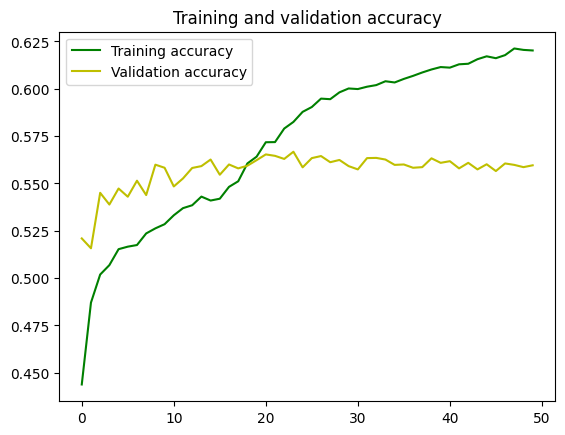

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

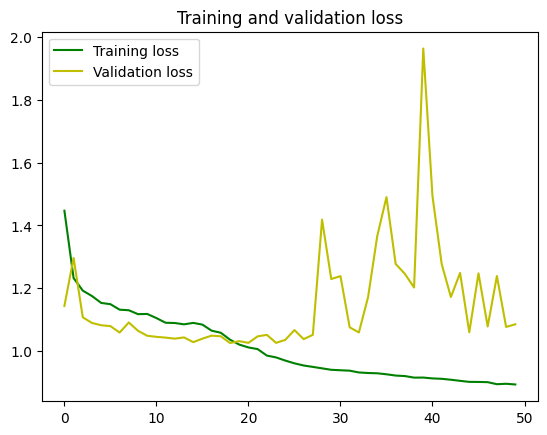

<Figure size 640x480 with 0 Axes>

In [22]:
# plot loss curves
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [2]:
def id2label(id):
    if id == 0:
        return "0-2"
    elif id == 1:
        return "10-19"
    elif id == 2:
        return "20-29"
    elif id == 3:
        return "3-9"
    elif id == 4:
        return "30-39"
    elif id == 5:
        return "40-49"
    elif id == 6:
        return "50-59"
    elif id == 7:
        return "60-69"
    elif id == 8:
        return "70+"

In [25]:
test_generator =  test_data.flow_from_directory( './ages_combined/Test',
                                                    batch_size  = batch_size,
                                                    class_mode  = 'categorical',
                                                    seed=seed,
                                                    target_size = target_size,
                                                    shuffle=False)

# Plotting some of the misclassified images with their true and predicted labels
print("Plotting some of the misclassified images with their true and predicted labels")
test_generator.reset()
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
print(pred)
print(test_generator.classes)
print(test_generator.class_indices)
print(test_generator.filenames)
misclassified_idx = np.where(pred != test_generator.classes)[0]
# Labels of the misclassified images
misclassified_labels = test_generator.classes[misclassified_idx]
print("Number of misclassified samples = ", len(misclassified_idx))
print("Total number of samples = ", len(test_generator.classes))
print("Percentage of misclassified samples = ", len(misclassified_idx)/len(test_generator.classes)*100, "%")




Found 4643 images belonging to 9 classes.
Plotting some of the misclassified images with their true and predicted labels
19/19 [==============================] - 6s 317ms/step
[3 0 0 ... 6 8 8]
[0 0 0 ... 8 8 8]
{'0-2': 0, '10-19': 1, '20-29': 2, '3-9': 3, '30-39': 4, '40-49': 5, '50-59': 6, '60-69': 7, '70+': 8}
['0-2\\10065.jpg', '0-2\\10074.jpg', '0-2\\10087.jpg', '0-2\\10164.jpg', '0-2\\1018.jpg', '0-2\\10210.jpg', '0-2\\10248.jpg', '0-2\\10295.jpg', '0-2\\10318.jpg', '0-2\\10319.jpg', '0-2\\10327.jpg', '0-2\\10331.jpg', '0-2\\10359.jpg', '0-2\\1036.jpg', '0-2\\10550.jpg', '0-2\\1060.png', '0-2\\10616.jpg', '0-2\\10652.jpg', '0-2\\10712.jpg', '0-2\\10714.jpg', '0-2\\10754.jpg', '0-2\\10774.jpg', '0-2\\10783.jpg', '0-2\\10845.jpg', '0-2\\10856.jpg', '0-2\\10892.jpg', '0-2\\10923.jpg', '0-2\\1132.jpg', '0-2\\1148.png', '0-2\\1200.jpg', '0-2\\1203.png', '0-2\\1265.jpg', '0-2\\1310.jpg', '0-2\\1362.jpg', '0-2\\1503.png', '0-2\\1516.png', '0-2\\152.jpg', '0-2\\1546.png', '0-2\\1565.png'

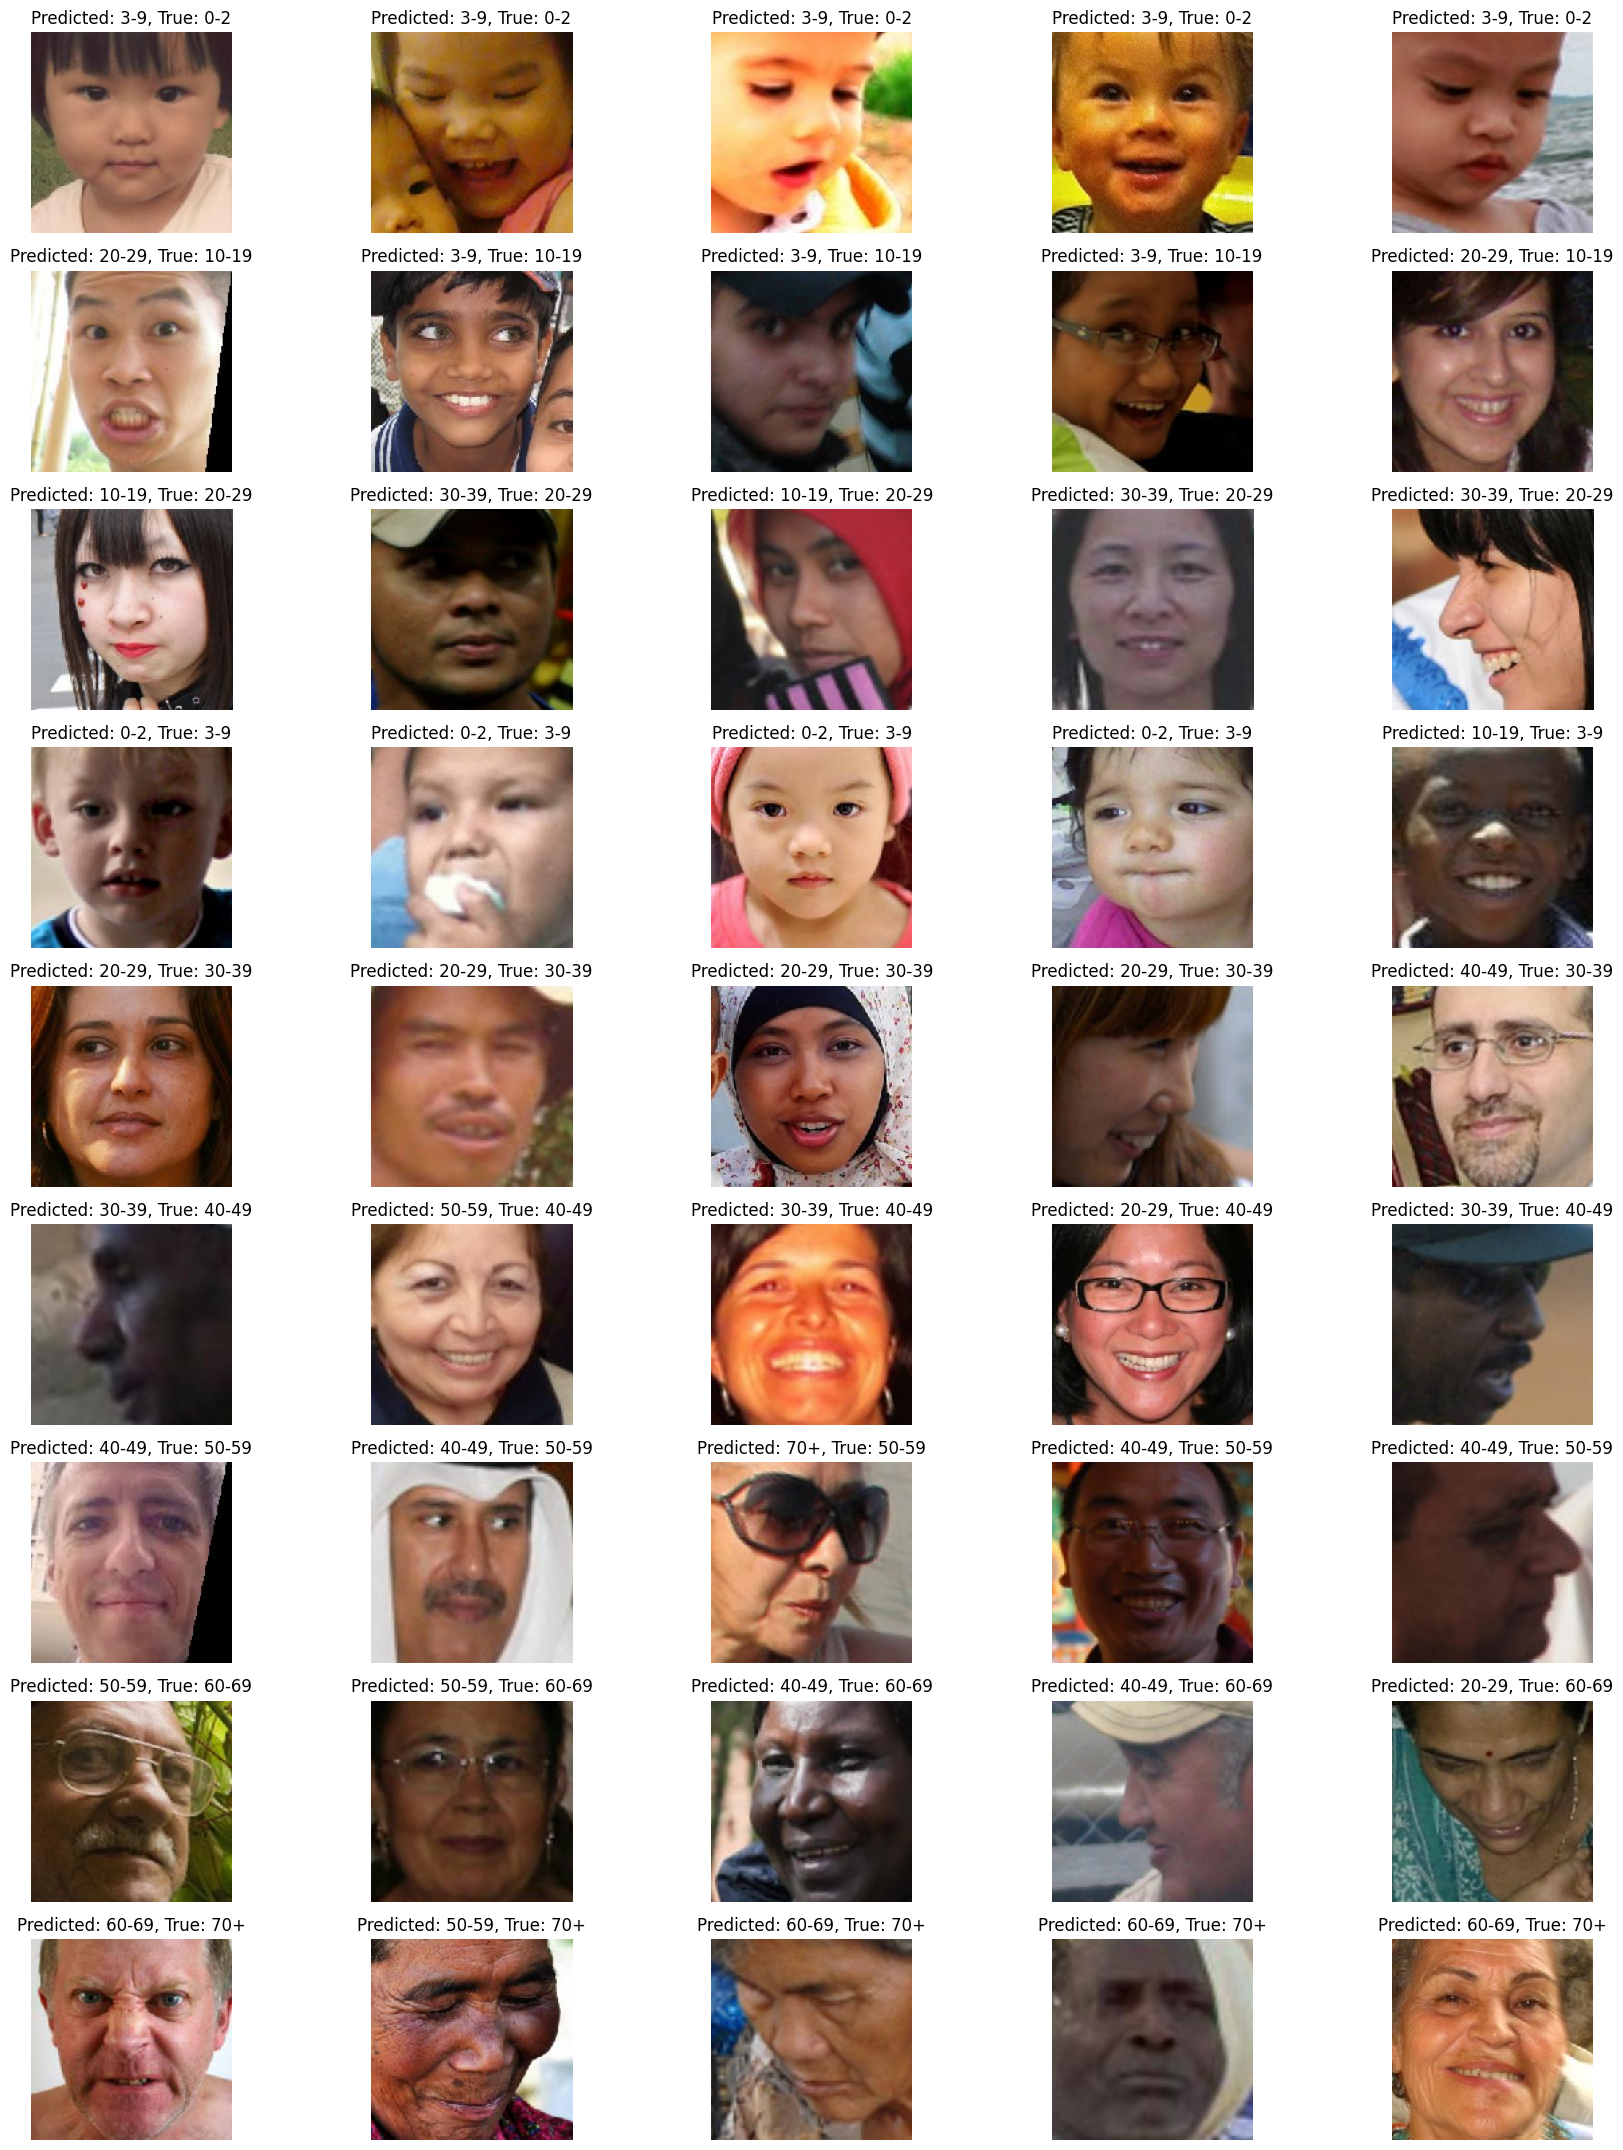

In [26]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ... [your previous code and function definitions] ...

def plot_misclassified_images(misclassified_idx, pred, true_labels, directory, filenames, id2label, target_size=(150, 150)):
    num_classes = 9
    images_per_class = 5
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(18, 21.6))  # Adjust the figsize if needed
    axes = axes.ravel()

    misclassified_counters = [0] * num_classes
    subplot_idx = 0

    for idx in misclassified_idx:
        true_label = true_labels[idx]
        if misclassified_counters[true_label] < images_per_class:
            misclassified_counters[true_label] += 1

            img_path = os.path.join(directory, filenames[idx])
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            axes[subplot_idx].imshow(img.astype('uint8'))
            axes[subplot_idx].set_title(f"Predicted: {id2label(pred[idx])}, True: {id2label(true_label)}")
            axes[subplot_idx].axis('off')
            subplot_idx += 1

            if subplot_idx >= num_classes * images_per_class:
                break

    for i in range(subplot_idx, num_classes * images_per_class):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example of calling the function
plot_misclassified_images(misclassified_idx, pred, test_generator.classes, test_generator.directory, test_generator.filenames, id2label)


{'0-2': 0, '10-19': 1, '20-29': 2, '3-9': 3, '30-39': 4, '40-49': 5, '50-59': 6, '60-69': 7, '70+': 8}
19/19 [==============================] - 6s 314ms/step
              precision    recall  f1-score   support

         0-2       0.80      0.87      0.84       212
       10-19       0.56      0.43      0.49       529
       20-29       0.60      0.72      0.65      1271
         3-9       0.75      0.76      0.75       574
       30-39       0.44      0.42      0.43       874
       40-49       0.46      0.44      0.45       522
       50-59       0.49      0.40      0.44       367
       60-69       0.42      0.44      0.43       174
         70+       0.76      0.53      0.62       120

    accuracy                           0.57      4643
   macro avg       0.59      0.56      0.57      4643
weighted avg       0.57      0.57      0.56      4643



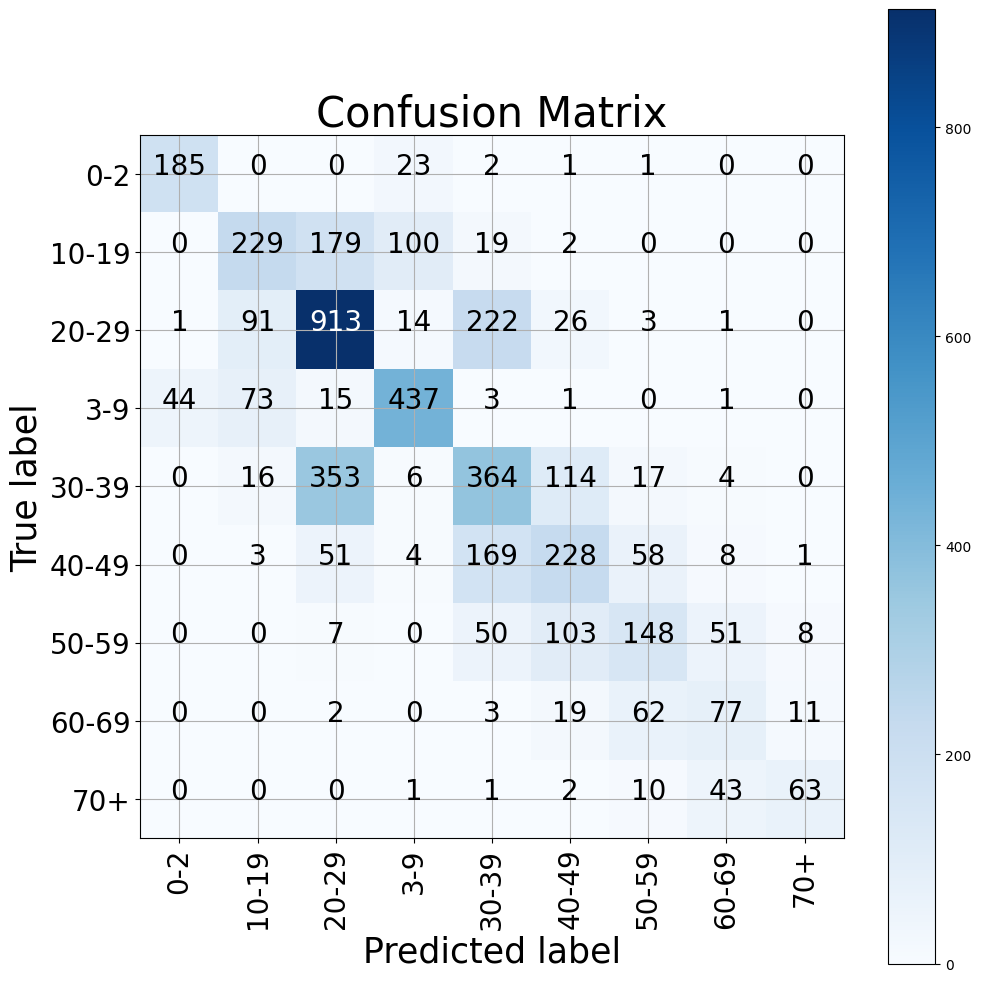

In [27]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    
    
        plt.figure(figsize=(10,10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=30)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
        plt.yticks(tick_marks, classes, fontsize=20)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
    
        # Labeling the plot
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            # plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
            plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', fontsize=25)
        plt.xlabel('Predicted label', fontsize=25)

# Get the labels of the test images.
test_labels = test_generator.classes

# We need these to plot the confusion matrix.
test_labels

# Print the label associated with each class
print(test_generator.class_indices)

# Generate predictions
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size+1, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]

# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = validation_generator.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Print the classification report
from sklearn.metrics import classification_report
# Generate a classification report

report = classification_report(test_labels, predicted_classes, target_names=validation_generator.class_indices.keys())

print(report)



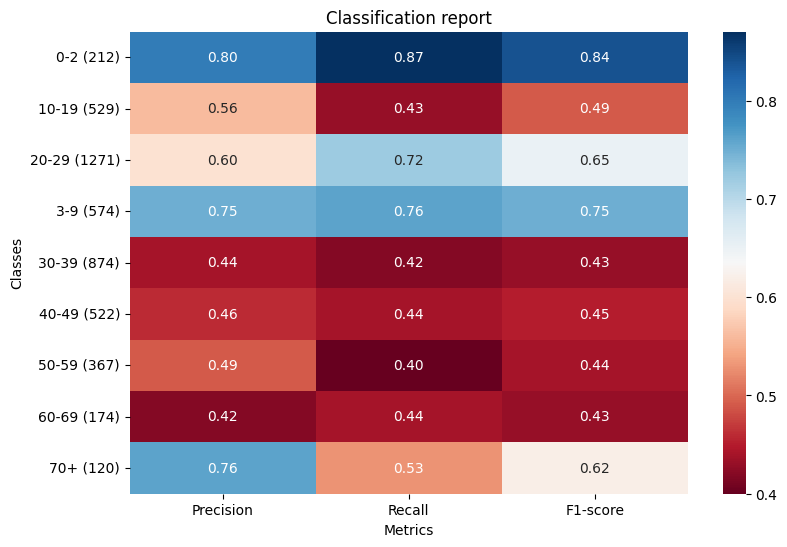

In [28]:

# Plot the classification report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_classification_report(classificationReport,
                                 title='Classification report',
                                 cmap='RdBu'):
     '''
     Plot scikit-learn classification report.
     Extension based on https://stackoverflow.com/a/31689645/395857
     '''
     classificationReport = classificationReport.replace('\n\n', '\n')
     classificationReport = classificationReport.replace(' / ', '/')
     lines = classificationReport.split('\n')
    
     classes, plotMat, support, class_names = [], [], [], []
     for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
          t = line.strip().split()
          if len(t) < 2:
                continue
          classes.append(t[0])
          v = [float(x) for x in t[1: len(t) - 1]]
          support.append(int(t[-1]))
          class_names.append(t[0])
          plotMat.append(v)
    
     plotMat = np.array(plotMat)
     xticklabels = ['Precision', 'Recall', 'F1-score']
     yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                     for idx, sup in enumerate(support)]
    
     plt.figure(figsize=(9, 6))
     sns.heatmap(plotMat, xticklabels=xticklabels,
                 yticklabels=yticklabels, cmap=cmap, annot=True, fmt='.2f')
     plt.title(title)
     plt.ylabel('Classes')
     plt.xlabel('Metrics')
     plt.savefig('classification_report.png')
     plt.show()

plot_classification_report(report)

In [29]:
def age_group_to_continuous(id):
    mapping = {
        0: 1,   # 0-2
        1: 14.5, # 10-19
        2: 24.5, # 20-29
        3: 6,    # 3-9
        4: 34.5, # 30-39
        5: 44.5, # 40-49
        6: 54.5, # 50-59
        7: 64.5, # 60-69
        8: 75    # 70+
    }
    return mapping.get(id, 0)

class_wise_misclassifications = {i: [] for i in range(9)}  # Assuming 9 classes

for idx in misclassified_idx:
    true_label = test_generator.classes[idx]
    predicted_label = pred[idx]
    magnitude = abs(age_group_to_continuous(predicted_label) - age_group_to_continuous(true_label))
    class_wise_misclassifications[true_label].append((idx, magnitude))

# Sort and select top 5 for each class
top_5_per_class = {class_id: sorted(class_wise_misclassifications[class_id], key=lambda x: x[1], reverse=True)[:5] for class_id in class_wise_misclassifications}


# # Sort by magnitude of error
# misclassified_magnitudes.sort(key=lambda x: x[1], reverse=True)

# top_5_misclassified = misclassified_magnitudes[:5]
# print("Top 5 worst misclassified samples:")
# for idx, magnitude in top_5_misclassified:
#     print(f"Index: {idx}, Predicted: {id2label(pred[idx])}, True: {id2label(test_generator.classes[idx])}, Magnitude: {magnitude}")



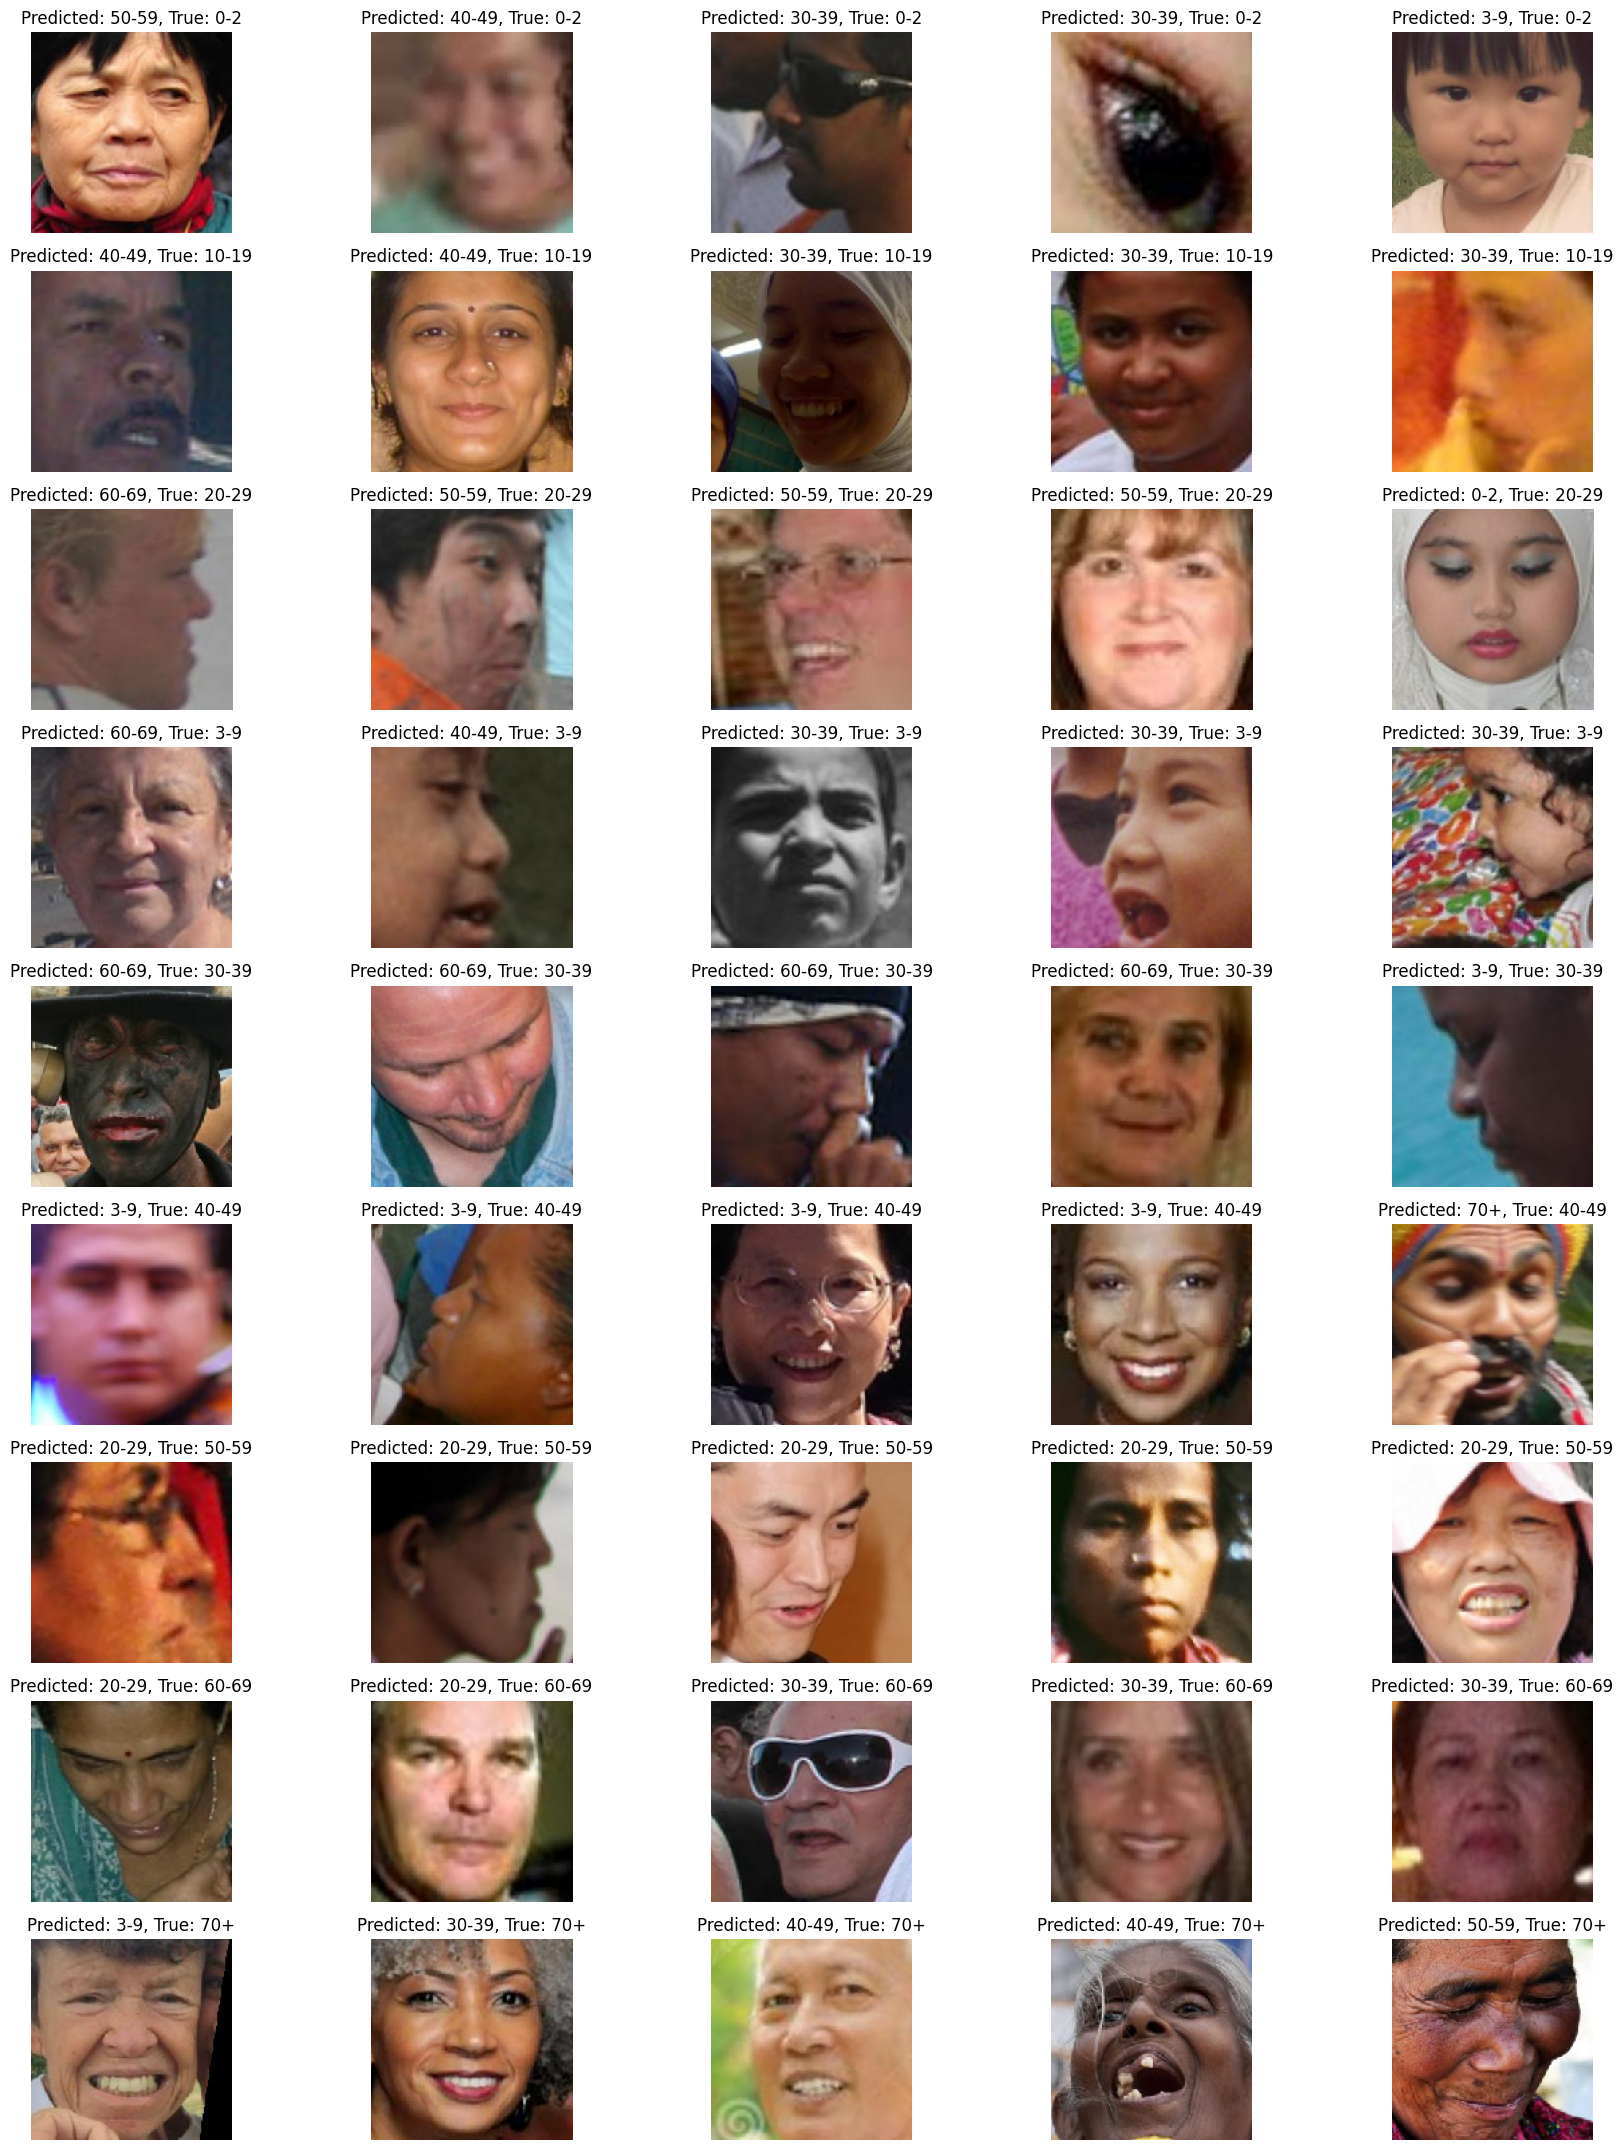

In [30]:
def plot_top_misclassified_images(top_5_per_class, pred, true_labels, directory, filenames, id2label, target_size=(150, 150)):
    num_classes = 9
    images_per_class = 5
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(18, 21.6))  # Adjust the figsize if needed
    axes = axes.ravel()

    subplot_idx = 0

    for class_id, misclassifications in top_5_per_class.items():
        for idx, _ in misclassifications:
            img_path = os.path.join(directory, filenames[idx])
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            axes[subplot_idx].imshow(img.astype('uint8'))
            axes[subplot_idx].set_title(f"Predicted: {id2label(pred[idx])}, True: {id2label(true_labels[idx])}")
            axes[subplot_idx].axis('off')
            subplot_idx += 1

    # Turn off remaining axes
    for i in range(subplot_idx, num_classes * images_per_class):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
plot_top_misclassified_images(top_5_per_class, pred, test_generator.classes, test_generator.directory, test_generator.filenames, id2label)


In [ ]:
print("Loading the model")
model = load_model('vggface_age_focal_combined_57.h5')

In [10]:
print("Testing the model on a sample image")
# sample_img_path = './my_friends/cumali.jpeg'
sample_img_path = './my_friends/cemre2.jpg'
# sample_img_path = './my_friends/bayzan.jpg'
# sample_img_path = './my_friends/engin.jpg'
# sample_img_path = './my_friends/halimcan.jpg'
# sample_img_path = './my_friends/halim2.jpeg'
# sample_img_path = './my_friends/cemre5.jpg'
# sample_img_path = './my_friends/engin2.jpg'
# sample_img_path = './my_friends/erto.jpg'
# sample_img_path = './my_friends/harry.jpg'
sample_img = tf.keras.preprocessing.image.load_img(sample_img_path, target_size=target_size)
sample_img = tf.keras.preprocessing.image.img_to_array(sample_img)
sample_img = np.expand_dims(sample_img, axis=0)
sample_img = sample_img/255
prediction = model.predict(sample_img)
print(prediction)
predicted_class = np.argmax(prediction)
print(id2label(predicted_class))


Testing the model on a sample image
1/1 [==============================] - 0s 31ms/step
[[2.7165157e-05 2.3574123e-02 6.4460391e-01 1.2802691e-04 3.0645722e-01
  2.3961363e-02 1.0366309e-03 1.8669013e-04 2.4920850e-05]]
20-29
